## prepare data

In [1]:
import pandas as pd
import numpy as np

from Bio.PDB.NeighborSearch import NeighborSearch
from Bio.PDB.Residue import Residue
from Bio.PDB.Atom import Atom
from Bio.SeqUtils import seq1
from typing import List


df_pdb_file = pd.read_table("~/database/pdb/rcsb_20230430/all_protein_files.csv")
dict_pdb_file = dict(zip(df_pdb_file['pdb'], df_pdb_file['pdb_file']))
df = pd.read_table("../nr_metal_sites.tsv")
resi_interact_distance_threshold = 9

In [2]:
import sys
sys.path.append(f"{PROJECT_DIR}/dataset/collect/scripts/utils")
from io_utils import parse_mmcif_file
from constants import common_amino_acids

def get_centroid(atoms: List[Atom]):
    
    atoms_coordinates = []
    for a in atoms:
        a: Atom
        atoms_coordinates.append(a.get_vector().get_array())
    cur_centroid = np.mean(np.array(atoms_coordinates), axis=0)
    return cur_centroid

In [3]:
dict_metal_site_to_resi_nb_info = dict()

for pdb, df_pdb in df.groupby(['pdb']):
    
    struct, _ = parse_mmcif_file(pdb, dict_pdb_file[pdb])
    model = next(struct.get_models())
    
    dict_id_to_resi = dict() # hetero id (chain pdb_seq_num) to resi
    atoms = []
    for r in model.get_residues():
        r: Residue
        if str.capitalize(r.get_resname()) in common_amino_acids:
            for a in r.get_atoms(): atoms.append(a)
        else: 
            chain, pdb_seq_num = r.get_full_id()[2], r.get_id()[1]
            dict_id_to_resi[(chain, pdb_seq_num)] = r
    ns = NeighborSearch(atoms)
    
    for chain_seq_num, df_site in df_pdb.groupby(['metal_chain', "metal_pdb_seq_num"]):
        
        target_resi: Residue
        target_atom: Atom
        
        metal_chain, metal_pdb_seq_num = chain_seq_num
        site = (pdb, metal_chain, metal_pdb_seq_num)
        
        target_resi = dict_id_to_resi[(metal_chain, metal_pdb_seq_num)]
        target_atoms = list(target_resi.get_atoms())
        target_atom_coord = None
        if len(target_atoms) > 1: target_atom_coord = get_centroid(target_atoms)
        else: target_atom_coord = target_atoms[0].get_vector().get_array()
        
        nb_resis_info = [] 
        nb_resis = ns.search(target_atom_coord, resi_interact_distance_threshold, level="R")
        for i in nb_resis:
            i: Residue
            distance = np.min([np.linalg.norm(a.get_vector().get_array() - target_atom_coord, 2) for a in i.get_atoms()])
            nb_resis_info.append((i.get_full_id(), distance, seq1(i.get_resname())))
        dict_metal_site_to_resi_nb_info[site] = nb_resis_info
        
# about half an hour

/tmp/ipykernel_19405/1305842294.py:3: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for pdb, df_pdb in df.groupby(['pdb']):


## get statistic data

In [4]:
from itertools import product
import math

x_axis = list([seq1(i) for i in common_amino_acids])
y_axis = [3, 6, 9]

dict_data = dict() # (aa_one_letter, interval) -> num
for key in product(x_axis, y_axis):
    dict_data[key] = 0
x_resi_set = set()
for v in dict_metal_site_to_resi_nb_info.values():
    for resi_info in v:
        full_id, distance, resname = resi_info
        assert resname in x_axis
        interval = math.ceil(distance / 3) * 3
        dict_data[(resname, interval)] += 1
data = [[*k, v] for k, v in dict_data.items()]

In [5]:
records = dict()
for d in data:
    aa, distance_interval, num = d
    if distance_interval not in records.keys():
        records[distance_interval] = dict()
    records[distance_interval][aa] = num

for k, v in records.items():
    total = sum(v.values())
    for v1 in v.keys():
        v[v1] = round(v[v1] / total * 100, 2) # to percent
        
true_records = []
for k, v in records.items():
    v["range"] = str(k)
    true_records.append(v)

 ## visualize

In [6]:
random = {
    'A': 8.76,
    'C': 1.38,
    'D': 5.49,
    'E': 6.32,
    'F': 3.87,
    'G': 7.03,
    'H': 2.26,
    'I': 5.49,
    'K': 5.19,
    'L': 9.68,
    'M': 2.32,
    'N': 3.93,
    'P': 5.02,
    'Q': 3.9,
    'R': 5.78,
    'S': 7.14,
    'T': 5.53,
    'V': 6.73,
    'W': 1.25,
    'Y': 2.91,
    'range': 'random'
} # Proteome-pI: proteome isoelectric point database, Nucleic Acids Research
true_records.append(random)
df = pd.DataFrame(true_records)
df = df[sorted(random.keys())]
df

,A,C,D,E,F,G,H,I,K,L,...,N,P,Q,R,S,T,V,W,Y,range
0,1.28,20.57,24.51,12.69,0.71,2.67,18.21,1.03,1.19,1.34,...,4.64,0.53,1.71,0.85,2.33,2.11,1.53,0.31,1.24,3
1,6.01,4.65,6.32,5.36,4.85,9.44,5.52,4.73,4.89,6.11,...,5.32,4.44,3.19,5.26,5.74,4.95,4.96,1.82,4.41,6
2,7.21,1.89,5.48,5.20,5.26,7.61,2.95,6.07,4.26,8.64,...,4.49,4.16,3.44,5.14,6.06,6.04,7.16,2.06,4.53,9
3,8.76,1.38,5.49,6.32,3.87,7.03,2.26,5.49,5.19,9.68,...,3.93,5.02,3.90,5.78,7.14,5.53,6.73,1.25,2.91,random


In [7]:
x = list(df.columns)[:-1]
y = dict()
for _, row in df.iterrows():
    y[row['range']] = list(dict(row).values())[:-1]

Text(0.5, 0, 'Amino acid')

Text(0, 0.5, 'Frequency (%)')

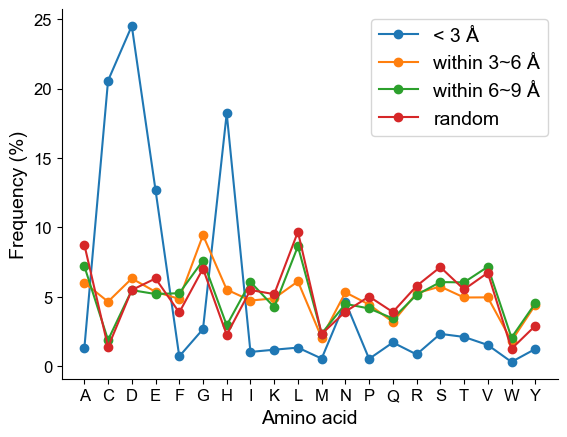

In [10]:
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = "Arial"

plt.plot(x, y['3'], marker='.', markersize=12)
plt.plot(x, y['6'], marker='.', markersize=12)
plt.plot(x, y['9'], marker='.', markersize=12)
plt.plot(x, y['random'], marker='.', markersize=12)

plt.legend(labels = ['< 3 Å', 'within 3~6 Å', 'within 6~9 Å', 'random'],
           fontsize=14)

ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
for t in ax.get_yticklabels():
    t.set_fontsize(12)
for t in ax.get_xticklabels():
    t.set_fontsize(12)
plt.xlabel("Amino acid", fontsize=14)
plt.ylabel("Frequency (%)", fontsize=14)

plt.savefig("./fig/distribution_ajacent_aa_freq.pdf", bbox_inches='tight')